In [1]:
import torch

In [2]:
!unzip /content/data.zip -d /content/


Archive:  /content/data.zip
   creating: /content/data/
  inflating: /content/data/eng-fra.txt  
   creating: /content/data/names/
  inflating: /content/data/names/Arabic.txt  
  inflating: /content/data/names/Chinese.txt  
  inflating: /content/data/names/Czech.txt  
  inflating: /content/data/names/Dutch.txt  
  inflating: /content/data/names/English.txt  
  inflating: /content/data/names/French.txt  
  inflating: /content/data/names/German.txt  
  inflating: /content/data/names/Greek.txt  
  inflating: /content/data/names/Irish.txt  
  inflating: /content/data/names/Italian.txt  
  inflating: /content/data/names/Japanese.txt  
  inflating: /content/data/names/Korean.txt  
  inflating: /content/data/names/Polish.txt  
  inflating: /content/data/names/Portuguese.txt  
  inflating: /content/data/names/Russian.txt  
  inflating: /content/data/names/Scottish.txt  
  inflating: /content/data/names/Spanish.txt  
  inflating: /content/data/names/Vietnamese.txt  


In [3]:
from io import open
import glob
import os

def findFiles(path):
  return glob.glob(path)

print(findFiles('/content/data/names/*.txt'))# modifies and adds the file name in the path

['/content/data/names/German.txt', '/content/data/names/Czech.txt', '/content/data/names/English.txt', '/content/data/names/Polish.txt', '/content/data/names/Greek.txt', '/content/data/names/Spanish.txt', '/content/data/names/Portuguese.txt', '/content/data/names/Japanese.txt', '/content/data/names/Arabic.txt', '/content/data/names/Korean.txt', '/content/data/names/Vietnamese.txt', '/content/data/names/Russian.txt', '/content/data/names/Irish.txt', '/content/data/names/Dutch.txt', '/content/data/names/Italian.txt', '/content/data/names/Chinese.txt', '/content/data/names/French.txt', '/content/data/names/Scottish.txt']


In [4]:
import unicodedata
import string

all_letters = string.ascii_letters+" ,.;'" #fetches all the characters and adds the special ones in ''
n_letters = len(all_letters)
'''
join to join all the characters obtained ,
normalize seperates characters with accenet , then we remove the accent
'''
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD',s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [5]:
category_lines = {}
all_categories = []

def readLines(filename):
  lines = open(filename,encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]


for filename in findFiles('/content/data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

In [6]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [7]:
import torch

def letterToIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor = torch.zeros(1,n_letters)#zeros returns a 2D array
  tensor[0][letterToIndex(letter)] = 1
  return tensor


def lineToTensor(line):
  tensor = torch.zeros(len(line),1,n_letters)#1 indicates it corresponds to onr line(also known as placeholder)
  for li,letter in enumerate(line):#The enumerate function returns 2 values everytime (the index and the item(value))
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(RNN,self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size,hidden_size)
    self.h2h = nn.Linear(hidden_size,hidden_size)
    self.h2o = nn.Linear(hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self,input,hidden):# Usual format of forward in RNNs.
    hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output,hidden

  def initHidden(self):
    return torch.zeros(1,self.hidden_size)#Used to initialize the first hidden layer since the first layer wont have any previous output.

n_hidden = 128
rnn = RNN(n_letters,n_hidden,n_categories)

In [9]:
input = lineToTensor('Albert')
hidden = torch.zeros(1,n_hidden)

output,next_hidden = rnn(input[0],hidden)
print(output)

tensor([[-2.9265, -2.7797, -2.9251, -3.0122, -2.8106, -2.8354, -2.8452, -2.9088,
         -2.7887, -2.9428, -3.0245, -2.8829, -2.8652, -2.8966, -2.9282, -2.8426,
         -2.9922, -2.8632]], grad_fn=<LogSoftmaxBackward0>)


In [10]:
def categoryFromOutput(output):
  top_n , top_i = output.topk(1)#top_n is the highest score and top_i is the index of the highest score.
  category_i = top_i[0].item()#Extract the index as python integer.
  return all_categories[category_i],category_i

print(categoryFromOutput(output))

('Czech', 1)


In [12]:
import random

def randomChoice(l):
  return l[random.randint(0,len(l)-1)]


def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Yamaguchi
category = Japanese / line = Tsuruya
category = Czech / line = Dolejsi
category = Dutch / line = Vann
category = German / line = Giese
category = Irish / line = Patrick
category = English / line = Farnworth
category = Russian / line = Hakhulin
category = Czech / line = Fremut
category = Greek / line = Rigatos


In [13]:
criterion = nn.NLLLoss()

In [16]:
category_tensor,line_tensor

(tensor([4]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,


In [17]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()
  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):#determins how many characters are there in the line.
    output,hidden = rnn(line_tensor[i],hidden)

  loss = criterion(output,category_tensor)
  loss.backward()

  for p in rnn.parameters():#manualy using Gradient Descend
    p.data.add_(p.grad.data,alpha=-learning_rate)

  return output,loss.item()

In [18]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 1.7233 Samios / Greek ✓
10000 10% (0m 19s) 1.9172 Flores / Portuguese ✗ (Spanish)
15000 15% (0m 28s) 1.2986 Song / Chinese ✗ (Korean)
20000 20% (0m 38s) 0.7056 Qiu / Chinese ✓
25000 25% (0m 47s) 0.3644 Hadad / Arabic ✓
30000 30% (0m 57s) 0.7048 Lefevre / French ✓
35000 35% (1m 5s) 5.2001 Gajos / Greek ✗ (Polish)
40000 40% (1m 15s) 0.2154 Dupont / French ✓
45000 45% (1m 24s) 0.0962 Callaghan / Irish ✓
50000 50% (1m 33s) 0.3674 Yi / Korean ✓
55000 55% (1m 43s) 0.1468 Slusarski / Polish ✓
60000 60% (1m 52s) 1.6575 Ventura / Spanish ✗ (Portuguese)
65000 65% (2m 1s) 3.5866 Busto / Scottish ✗ (Spanish)
70000 70% (2m 10s) 1.0027 Fillipova / Czech ✓
75000 75% (2m 20s) 0.9041 Seow / Chinese ✓
80000 80% (2m 29s) 0.3406 Agrioli / Italian ✓
85000 85% (2m 38s) 0.1358 Sacco / Italian ✓
90000 90% (2m 47s) 1.0652 Joss / English ✓
95000 95% (2m 57s) 0.1348 Meng / Chinese ✓
100000 100% (3m 6s) 0.4214 Mozzis / Czech ✓


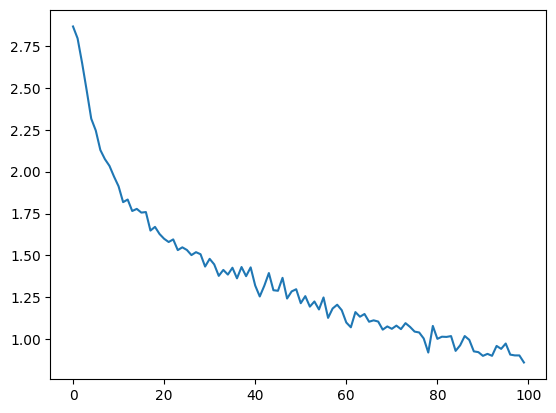

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-20-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-20-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


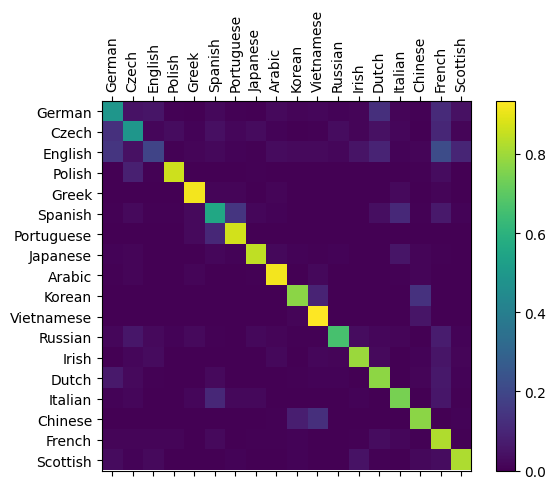

In [20]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()